<a href="https://colab.research.google.com/github/malborroni/RECMojion/blob/master/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Librerie

In [1]:
! sudo pip install git+https://github.com/rcmalli/keras-vggface.git

  Cloning https://github.com/rcmalli/keras-vggface.git to /tmp/pip-req-build-fp9hldkx
  Running command git clone -q https://github.com/rcmalli/keras-vggface.git /tmp/pip-req-build-fp9hldkx
  Created wheel for keras-vggface: filename=keras_vggface-0.6-cp36-none-any.whl size=8311 sha256=1ac1fad2a7795ab801661f851b2a293bbecf7bb9c09c06dcb90456440bb546aa
  Stored in directory: /tmp/pip-ephem-wheel-cache-vu97pqkl/wheels/36/07/46/06c25ce8e9cd396dabe151ea1d8a2bc28dafcb11321c1f3a6d
Successfully built keras-vggface


In [2]:
# Example of face detection with a vggface2 model
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import pandas as pd
import random as rnd

import seaborn as sns
from matplotlib import style
style.use('seaborn-pastel')

import keras
from keras.layers import Dense, Dropout, Flatten, Activation, Conv2D, MaxPooling2D
from keras.models import Model, Sequential, load_model
from keras.utils import to_categorical
from keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
import keras_vggface
from keras_vggface.vggface import VGGFace
from keras_vggface.utils import preprocess_input, decode_predictions
from keras import regularizers
from keras.callbacks import EarlyStopping, ModelCheckpoint 
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import os
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split,StratifiedKFold

import random
import pickle

Using TensorFlow backend.


In [0]:
# fix random seed for reproducibility
seed = 42
np.random.seed(seed)

# Funzioni

In [0]:
def graph(history):
  # funzione che prende in input il modello fittato e fa un plot della loss in validation e train
  epochs=len(history.history['loss'])
  x_plot = list(range(1,epochs+1))
  plt.figure()
  
  plt.subplot(1, 2, 1)
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.plot(x_plot, history.history['loss'])
  plt.plot(x_plot, history.history['val_loss'])
  plt.legend(['Training', 'Validation'])

  
  plt.subplot(1, 2, 2)
  plt.xlabel('Epochs')
  plt.ylabel('Acc')
  plt.plot(x_plot, history.history['acc'])
  plt.plot(x_plot, history.history['val_acc'])
  plt.legend(['Training', 'Validation'])
  
  plt.tight_layout()
  plt.show()


#Dataset

Il dataset si trova in un file chiamato XY.pkl nel drive 

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
data = np.load('/content/drive/My Drive/Colab Notebooks/AML/data_aug_complete.npz')

In [25]:
# training set
x_train = data['x_train']
y_train = data['y_train']

# validation set
x_val = data['x_val']
y_val = data['y_val']

# test set
x_test = data['x_test']
y_test = data['y_test']

print('Shape del training set: {} --- {}\nShape del validation set: {} --- {}\nShape del test set: {} --- {}'. format(x_train.shape, y_train.shape,
                                                                                                                 x_val.shape, y_val.shape,
                                                                                                                 x_test.shape, y_test.shape))

Shape del training set: (2157, 224, 224, 3) --- (2157,)
Shape del validation set: (415, 224, 224, 3) --- (415,)
Shape del test set: (518, 224, 224, 3) --- (518,)


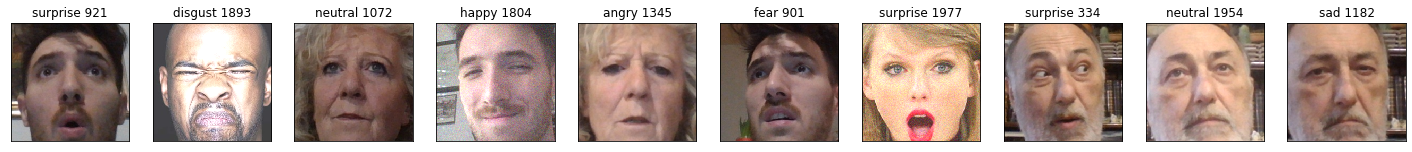

In [8]:
plt.figure(figsize=(25, 8))
nimages = 10 
for i in range(nimages):
    ax = plt.subplot(2, nimages, i + 1)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    l = random.randint(0, len(y_train))
    plt.imshow(x_train[l][:,:,::-1])
    plt.title(str(y_train[l])+' '+str(l))

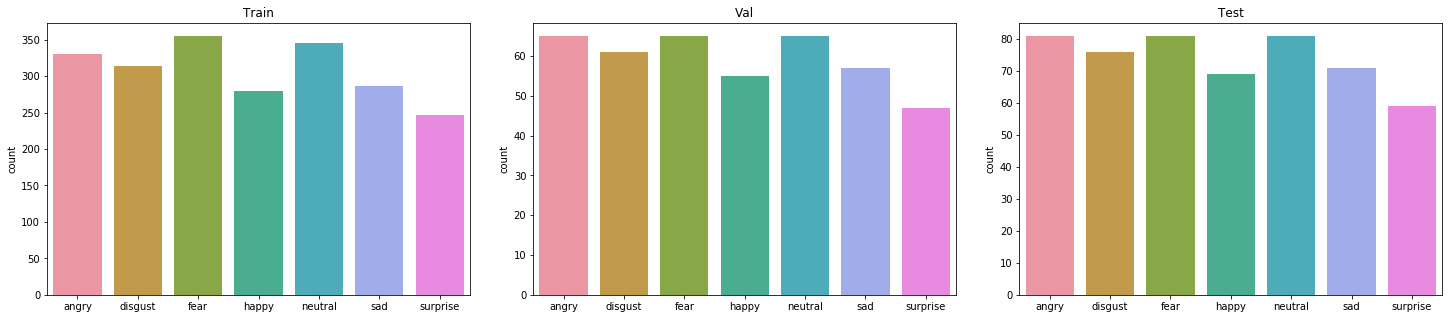

In [9]:
order =  ['angry','disgust','fear','happy','neutral','sad','surprise']

fig = plt.figure(figsize = (25,5))
fig.subplots_adjust(hspace=0, wspace=0.15)
ax = fig.add_subplot(1, 3, 1)
ax.set_title('Train')
sns.countplot(y_train, order = order)
ax = fig.add_subplot(1, 3, 2)
ax.set_title('Val')
sns.countplot(y_val, order = order)
ax = fig.add_subplot(1, 3, 3)
ax.set_title('Test')
sns.countplot(y_test, order = order)
plt.show()

In [0]:
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_train = to_categorical(y_train, num_classes = 7)
y_test = le.fit_transform(y_test)
y_test = to_categorical(y_test, num_classes = 7)
y_val = le.fit_transform(y_val)
y_val = to_categorical(y_val, num_classes = 7)

In [0]:
x_train = x_train.astype('float64')
x_test = x_test.astype('float64')
x_val = x_val.astype('float64')
x_train = preprocess_input(x_train, version=2)
x_test = preprocess_input(x_test, version=2)
x_val = preprocess_input(x_val, version=2)

In [12]:
np.max(x_train), np.min(x_train), x_train.shape, np.max(x_val), np.min(x_val), x_val.shape, np.max(x_test), np.min(x_test), x_test.shape

(163.5047,
 -131.0912,
 (2157, 224, 224, 3),
 163.5047,
 -131.0912,
 (415, 224, 224, 3),
 163.5047,
 -131.0912,
 (518, 224, 224, 3))

## Feature Extration

In [28]:
base_model = VGGFace(include_top = False, input_shape = (224, 224, 3), model='senet50')
base_model.summary()

Model: "vggface_senet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1/7x7_s2 (Conv2D)           (None, 112, 112, 64) 9408        input_2[0][0]                    
__________________________________________________________________________________________________
conv1/7x7_s2/bn (BatchNormaliza (None, 112, 112, 64) 256         conv1/7x7_s2[0][0]               
__________________________________________________________________________________________________
activation_82 (Activation)      (None, 112, 112, 64) 0           conv1/7x7_s2/bn[0][0]            
____________________________________________________________________________________

In [0]:
layer_cut = "conv5_3_1x1_reduce"
model = Model(inputs=base_model.input, outputs=base_model.get_layer(layer_cut).output)

In [0]:
x_train_fe = model.predict(x_train)
x_val_fe = model.predict(x_val)
x_test_fe = model.predict(x_test)

# Modello

In [0]:
def create_model():
  # Create model
  model = Sequential()
  # C1
  model.add(Conv2D(32, kernel_size=1, activation='relu', input_shape= (7, 7, 512)))
  model.add(Conv2D(128, kernel_size=3, activation='relu'))
  model.add(Conv2D(32, kernel_size=1, activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Flatten())
  # D
  model.add(Dense(210, activation='relu')) # 21-28-56 buono 224 best
  model.add(Dropout(0.5)) # 0.5
  model.add(Dense(7, activation='softmax'))
  # Compile model
  model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['acc'])
  return model

Start 1/5
Train on 2157 samples, validate on 415 samples
Epoch 1/100
2157/2157 [==============================] - 6s 3ms/step - loss: 1.9346 - acc: 0.1757 - val_loss: 1.9117 - val_acc: 0.2048

Epoch 00001: val_acc improved from -inf to 0.20482, saving model to /content/drive/My Drive/Colab Notebooks/AML/cnn.best.h5
Epoch 2/100
2157/2157 [==============================] - 0s 106us/step - loss: 1.8625 - acc: 0.2703 - val_loss: 1.7461 - val_acc: 0.4024

Epoch 00002: val_acc improved from 0.20482 to 0.40241, saving model to /content/drive/My Drive/Colab Notebooks/AML/cnn.best.h5
Epoch 3/100
2157/2157 [==============================] - 0s 108us/step - loss: 1.5639 - acc: 0.4205 - val_loss: 1.3513 - val_acc: 0.5566

Epoch 00003: val_acc improved from 0.40241 to 0.55663, saving model to /content/drive/My Drive/Colab Notebooks/AML/cnn.best.h5
Epoch 4/100
2157/2157 [==============================] - 0s 108us/step - loss: 1.2602 - acc: 0.5522 - val_loss: 1.1136 - val_acc: 0.6193

Epoch 00004: va

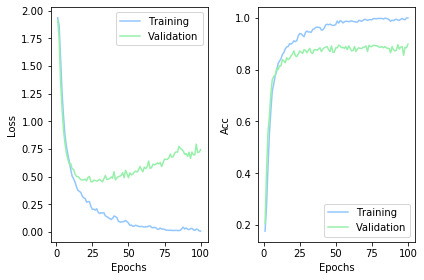

518/518 [==============================] - 0s 138us/step
Post-training accuracy: 89.575 %
Post-training loss: 0.6743
Start 2/5
Train on 2157 samples, validate on 415 samples
Epoch 1/100


KeyboardInterrupt: ignored

In [46]:
# config model
batch_size = 128
num_epoch = 100

# callbacks
filepath = "/content/drive/My Drive/Colab Notebooks/AML/cnn.best.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1,restore_best_weights=True) 
callbacks_list = [early_stop, checkpoint]


acc_scores= []
loss_scores = []
fold = 5
for i in range(fold):
  print('Start {}/{}'.format(i+1, fold))
  # crate model
  model = create_model()

  # Fit the model
  model_log = model.fit(x_train_fe, y_train,
        batch_size=batch_size,
        epochs=num_epoch,
        verbose=1,
        validation_data=(x_val_fe, y_val),
        callbacks=callbacks_list)

  # visualize graph
  graph(model_log)

  # Evaluate the model
  model.load_weights(filepath)
  scores = model.evaluate(x_test_fe, y_test, verbose=1)
  accuracy = 100*scores[1]
  loss = scores[0]
  print("Post-training accuracy: {} %".format(round(accuracy, 3)))
  print("Post-training loss: {}".format(round(loss, 4)))
  acc_scores.append(accuracy)
  loss_scores.append(loss)
    


In [35]:
print("mean accuracy: {}% (sd: +/- {}%)".format(round(np.mean(acc_scores), 2), round(np.std(acc_scores), 2)))
print("mean loss: {}  (sd: +/- {} )".format(np.mean(loss_scores), np.std(loss_scores)))

mean accuracy: 89.77% (sd: +/- 1.06%)
mean loss: 0.4208795387887586  (sd: +/- 0.025763996284714076 )


In [19]:
y_true = np.argmax(y_test,axis=1)
y_pred = model.predict_classes(x_test)
print(classification_report(y_true, y_pred, target_names = le.inverse_transform([0,1,2,3,4,5,6])))

              precision    recall  f1-score   support

       angry       0.84      0.86      0.85        81
     disgust       0.91      0.92      0.92        76
        fear       0.89      0.84      0.87        81
       happy       0.92      0.99      0.95        69
     neutral       0.90      0.89      0.89        81
         sad       0.93      0.97      0.95        71
    surprise       0.91      0.83      0.87        59

    accuracy                           0.90       518
   macro avg       0.90      0.90      0.90       518
weighted avg       0.90      0.90      0.90       518



In [0]:
lab_test = le.inverse_transform(np.argmax(y_test, axis=1))
lab_pred = le.inverse_transform(y_pred)

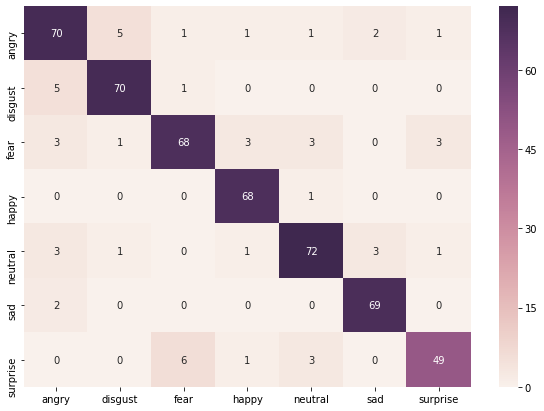

In [21]:
etichette = ['angry','disgust','fear','happy','neutral','sad','surprise']
cm = confusion_matrix(lab_test, lab_pred)
df_cm = pd.DataFrame(cm, index = etichette, columns = etichette)
# if u want percentage (reacll)
# cm_p = cm / cm.astype(np.float).sum(axis=1)
# df_cm = pd.DataFrame(cm_p, index = etichette, columns = etichette)
plt.figure(figsize = (10,7))
cmap=sns.cubehelix_palette(100000, dark=0.2, light=0.95)
sns.heatmap(df_cm, annot=True, cmap=cmap)
plt.show()

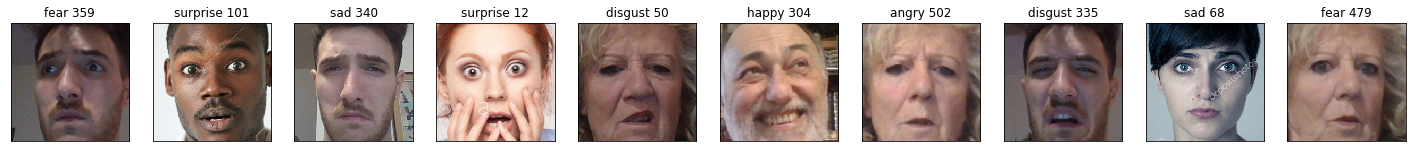

In [22]:
images = data['x_test']
plt.figure(figsize=(25, 8))
nimages = 10 
for i in range(nimages):
    ax = plt.subplot(2, nimages, i + 1)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    l = random.randint(0, len(lab_pred))
    plt.imshow(images[l][:,:,::-1])
    plt.title(str(lab_pred[l])+' '+str(l))

del images

Salvataggio accuracy

In [0]:
# import json
# kfold_acc = {}
# kfold_acc["CNN"]=(np.mean(cvscores), np.std(cvscores))
# json = json.dumps(kfold_acc)

# f = open("/content/drive/My Drive/AML/kfold_acc.json","w")
# f.write(json)
# f.close()